In [1]:
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
batch_size = 64 # Batch size for training.
epochs = 130 # Number of epochs to train for.
latent_dim = 512 # Latent dimensionality of the encoding space.
num_samples = 7000 # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'
num_samples

7000

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    ind,input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 7000
Number of unique input tokens: 91
Number of unique output tokens: 115
Max sequence length for inputs: 228
Max sequence length for outputs: 162


In [4]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [5]:
# Define an input sequence and process it.
#MODEL CHECKPOINT
ckpt_file = 'char_model.h1.27_jul_19'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

W0728 18:58:26.499808  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 18:58:26.533692  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 18:58:26.545690  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [6]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
model.summary()

W0728 18:58:27.752550  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 18:58:27.772497  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 91)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 115)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 1236992     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  1286144     input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [7]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

W0728 18:58:31.309172  3000 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 18:58:32.183989  3000 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5600 samples, validate on 1400 samples
Epoch 1/130
5600/5600 [==============================] - 62s 11ms/step - loss: 0.6607 - acc: 0.0426 - val_loss: 0.5871 - val_acc: 0.0553
Epoch 2/130
5600/5600 [==============================] - 53s 9ms/step - loss: 0.5351 - acc: 0.0624 - val_loss: 0.4982 - val_acc: 0.0705
Epoch 3/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.4690 - acc: 0.0755 - val_loss: 0.4518 - val_acc: 0.0786
Epoch 4/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.4384 - acc: 0.0814 - val_loss: 0.4307 - val_acc: 0.0830
Epoch 5/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.4179 - acc: 0.0855 - val_loss: 0.4123 - val_acc: 0.0864
Epoch 6/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.4011 - acc: 0.0890 - val_loss: 0.4034 - val_acc: 0.0897
Epoch 7/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.3882 - acc: 0.0920 - val_loss: 0.3911 - val_acc: 0

5600/5600 [==============================] - 55s 10ms/step - loss: 0.0799 - acc: 0.1749 - val_loss: 0.5693 - val_acc: 0.0937
Epoch 61/130
5600/5600 [==============================] - 55s 10ms/step - loss: 0.0787 - acc: 0.1751 - val_loss: 0.5746 - val_acc: 0.0937
Epoch 62/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0773 - acc: 0.1755 - val_loss: 0.5732 - val_acc: 0.0937
Epoch 63/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0763 - acc: 0.1756 - val_loss: 0.5834 - val_acc: 0.0937
Epoch 64/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0752 - acc: 0.1760 - val_loss: 0.5831 - val_acc: 0.0942
Epoch 65/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0744 - acc: 0.1761 - val_loss: 0.5865 - val_acc: 0.0937
Epoch 66/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0735 - acc: 0.1763 - val_loss: 0.5877 - val_acc: 0.0943
Epoch 67/130
5600/5600 [=======================

5600/5600 [==============================] - 54s 10ms/step - loss: 0.0473 - acc: 0.1823 - val_loss: 0.6925 - val_acc: 0.0947
Epoch 120/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0472 - acc: 0.1823 - val_loss: 0.6984 - val_acc: 0.0945
Epoch 121/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0469 - acc: 0.1824 - val_loss: 0.6983 - val_acc: 0.0947
Epoch 122/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0464 - acc: 0.1826 - val_loss: 0.6994 - val_acc: 0.0951
Epoch 123/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0461 - acc: 0.1826 - val_loss: 0.6969 - val_acc: 0.0950
Epoch 124/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0461 - acc: 0.1826 - val_loss: 0.6982 - val_acc: 0.0944
Epoch 125/130
5600/5600 [==============================] - 54s 10ms/step - loss: 0.0455 - acc: 0.1828 - val_loss: 0.6998 - val_acc: 0.0951
Epoch 126/130
5600/5600 [================

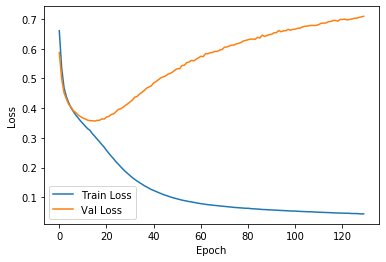

In [9]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

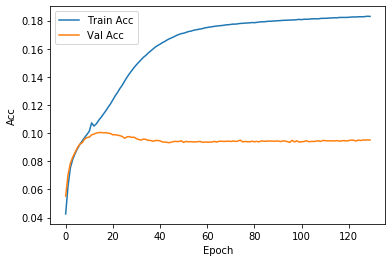

In [10]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

In [11]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [12]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [13]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [77]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: I do not want to die.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: It's the same country I think.
Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

-
Input sentence: Then they'll be crying like babies.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: - No, I need power up!
Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

-
Input sentence: I will not eat him.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: You gotta get me to Charleston.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: - NO, HE'S NOT MY DAD.
Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

-
Input sentence: I told her we rest on Sundays.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: You could've at least informed me, right?
De

-
Input sentence: Come, Macedonians.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: How's her hair?
Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

-
Input sentence: Hey, hey.
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: Whoa! Astrid!
Decoded sentence: तुम मुझे साथ लेंगे?

-
Input sentence: Let's not repeat the same mistakes that we made in the past.
Decoded sentence: यह एक बच्चा है. हो!

-
Input sentence: Jack always told me that if anything should ever happened to him.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: I want you to come home.
Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

-
Input sentence: Carver just told me we're not gonna tell anybody what happened up there.
Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

-
Input sentence: Prove to us you are who you say you are.
Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

-
Input sentence: The Spirit Realm.
Decoded sentence: यह एक बहु

In [78]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:',decoded_sentence)
    print('Individual 1-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(1, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 1, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 1, 0)))
    print('Individual 4-gram: %f' % sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 0, 1)))
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights =(0.25,0.25,0.25,0.25))
    print('4-gram cumm BLEU score:',BLEUscore)

-
Input sentence: I do not want to die.
Target sentence: 	मैं मरना नहीं चाहता.

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 0.485714
Individual 2-gram: 0.235294
Individual 3-gram: 0.090909
Individual 4-gram: 0.031250
4-gram cumm BLEU score: 0.13423393480752616
-
Input sentence: It's the same country I think.
Target sentence: 	यह मुझे लगता है कि एक ही देश है.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.571429
Individual 2-gram: 0.219512
Individual 3-gram: 0.100000
Individual 4-gram: 0.051282
4-gram cumm BLEU score: 0.15925625475624441
-
Input sentence: Then they'll be crying like babies.
Target sentence: 	फिर ये नन्हें बच्चों की तरह रोएँगे।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.468085
Individual 2-gram: 0.152174
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 7.70616801416754e-155


C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


-
Input sentence: - No, I need power up!
Target sentence: 	नहीं, मुझे पावर की जरुरत है !

Decoded sentence: - मैं तुम सो करोसे को रूप में प्रति कर दीता, तुम की रहे में पड़े सुकाने पता है तो बच्चाई की को माफ़ा था.

Individual 1-gram: 0.247619
Individual 2-gram: 0.115385
Individual 3-gram: 0.048544
Individual 4-gram: 0.019608
4-gram cumm BLEU score: 0.07221437216022507
-
Input sentence: I will not eat him.
Target sentence: 	मैं उसे नहीं खा जाएगा.

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 0.428571
Individual 2-gram: 0.235294
Individual 3-gram: 0.060606
Individual 4-gram: 0.031250
4-gram cumm BLEU score: 0.11755743200908036
-
Input sentence: You gotta get me to Charleston.
Target sentence: 	आप चार्ल्सटन करने के लिए मुझे जाना होगा.

Decoded sentence: तुम मुझे साथ लेंगे?

Individual 1-gram: 0.233010
Individual 2-gram: 0.105117
Individual 3-gram: 0.073971
Individual 4-gram: 0.058742
4-gram cumm BLEU score: 0.10156988182544098
-
Input sentence: - NO, HE'S NOT MY

-
Input sentence: Let's be real hot (nicer) I am of you
Target sentence: 	चलो तुम हो गरम रियल (अच्छे) का रहा हूँ मैं

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.574468
Individual 2-gram: 0.195652
Individual 3-gram: 0.088889
Individual 4-gram: 0.045455
4-gram cumm BLEU score: 0.14598016331402125
-
Input sentence: Look, I know I quit the academy before.
Target sentence: 	मैं मैं पहले अकादमी छोड़ने पता है, देखो.

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.468085
Individual 2-gram: 0.152174
Individual 3-gram: 0.022222
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 2.436123141043727e-78
-
Input sentence: We village elders still exist.
Target sentence: 	हम गांव के बुजुर्ग अभी भी मौजूद हैं.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.571429
Individual 2-gram: 0.121951
Individual 3-gram: 0.025000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 2.49521593209797

C:\Users\ryepu\.conda\envs\deeplearning\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


-
Input sentence: Everybody, come on!
Target sentence: 	, वापस जाओ! ,

Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

Individual 1-gram: 0.171429
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 1.1722739790570059e-231
-
Input sentence: For the lady!
Target sentence: 	महिला के लिए!

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.261905
Individual 2-gram: 0.073171
Individual 3-gram: 0.025000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 1.806929915871479e-78
-
Input sentence: Keep coming.
Target sentence: 	आते रहना.

Decoded sentence: मैं तुम्हें पता था निक ला समय ली जावत है.

Individual 1-gram: 0.190476
Individual 2-gram: 0.024390
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 3.8943629578389926e-155
-
Input sentence: I will find you!
Target sentence: 	मैं तुम्हें मिल जाएगा!

Decoded sentence: मैं तुम्हें पता था निक लर रहे हैं.

Individual 1-gram: 

-
Input sentence: Carver just told me we're not gonna tell anybody what happened up there.
Target sentence: 	कार्वर ने बताया कि हमें उस घटना का ज़िक्र किसी से नहीं करना है।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.493237
Individual 2-gram: 0.207513
Individual 3-gram: 0.060607
Individual 4-gram: 0.015496
4-gram cumm BLEU score: 0.09901727490911837
-
Input sentence: Prove to us you are who you say you are.
Target sentence: 	हमें सिद्ध करो ... ... तुम जो कहते हो, वो हो.

Decoded sentence: क्या तुम मुझे क्या करना चाहते हैं?

Individual 1-gram: 0.425844
Individual 2-gram: 0.229622
Individual 3-gram: 0.150551
Individual 4-gram: 0.088717
4-gram cumm BLEU score: 0.19010293311581275
-
Input sentence: The Spirit Realm.
Target sentence: 	आत्मा मंडल।

Decoded sentence: यह एक बहुत प्रभा करता था, और तुम उस जानते हों.

Individual 1-gram: 0.148936
Individual 2-gram: 0.021739
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cumm BLEU score: 3

In [17]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [18]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:',decoded_sentence)
    x1=sentence_bleu([target_sentence], decoded_sentence, weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], decoded_sentence, weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], decoded_sentence, weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append(decoded_sentence)
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: 	मैं मरना नहीं चाहता.

Decoded sentence: मैं तुम्हारे घटियाप के लिए के लिए पूर्व रात कर रहा हूँ, लेकिन में फ्लारिप रहे हैं कि सेंद्राफित कर रहे हैं.

Individual 1-gram: 0.166667
Individual 2-gram: 0.065421
Individual 3-gram: 0.018868
Individual 4-gram: 0.009524
4-gram cummulative score:  0.037413165993967976
-
Input sentence: It's the same country I think.
Target sentence: 	यह मुझे लगता है कि एक ही देश है.

Decoded sentence: यह मेरा कार्यालय है.

Individual 1-gram: 0.358971
Individual 2-gram: 0.242306
Individual 3-gram: 0.141699
Individual 4-gram: 0.089743
4-gram cummulative score:  0.18236758077481025
-
Input sentence: Then they'll be crying like babies.
Target sentence: 	फिर ये नन्हें बच्चों की तरह रोएँगे।

Decoded sentence: तो कहानी बदल जाते हैं.

Individual 1-gram: 0.354822
Individual 2-gram: 0.098920
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  4.7623272603616104e-155
-
Input sentence: -

-
Input sentence: Feels like there's something in there.
Target sentence: 	वहाँ में कुछ है जैसे लगता है.

Decoded sentence: जाओ.

Individual 1-gram: 0.004413
Individual 2-gram: 0.001379
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  5.502986009999541e-157
-
Input sentence: This is your honeymoon suite.
Target sentence: 	यह अपने हनीमून सुइट है।

Decoded sentence: यह मेरा कार्यालय है.

Individual 1-gram: 0.393603
Individual 2-gram: 0.165313
Individual 3-gram: 0.087007
Individual 4-gram: 0.000000
4-gram cummulative score:  3.1943692996762804e-78
-
Input sentence: and religious interests to agree on a single treaty..
Target sentence: 	बाईस अरब देश एक ही संधि पर तैयार हो जाएंगे

Decoded sentence: अपने प्रेमी के घर के लिए।

Individual 1-gram: 0.307951
Individual 2-gram: 0.060050
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  3.891246789207348e-155
-
Input sentence: Let's be real hot (nicer) I am of you
Target sentence: 	

-
Input sentence: For the lady!
Target sentence: 	महिला के लिए!

Decoded sentence: चलो चलते हैं डौग के साथ हुक.

Individual 1-gram: 0.310345
Individual 2-gram: 0.107143
Individual 3-gram: 0.074074
Individual 4-gram: 0.038462
4-gram cummulative score:  0.09865637517691195
-
Input sentence: Keep coming.
Target sentence: 	आते रहना.

Decoded sentence: अपने बैग में रखें और छोड़

Individual 1-gram: 0.192308
Individual 2-gram: 0.080000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  5.253441210115029e-155
-
Input sentence: I will find you!
Target sentence: 	मैं तुम्हें मिल जाएगा!

Decoded sentence: मैं तुम्हारे घटियाप के लिए के लिए पूर्व रात कर रहा हूँ, लेकिन में फ्लारिप रहे हैं कि सेंद्राफित कर रहे हैं

Individual 1-gram: 0.186916
Individual 2-gram: 0.113208
Individual 3-gram: 0.076190
Individual 4-gram: 0.057692
4-gram cummulative score:  0.09820532776122973
-
Input sentence: Our agency passed suspension order against him
Target sentence: 	हमारे एजेंसी उनक

-
Input sentence: Prove to us you are who you say you are.
Target sentence: 	हमें सिद्ध करो ... ... तुम जो कहते हो, वो हो.

Decoded sentence: उसे लूप नहीं जाना चुहिए

Individual 1-gram: 0.207746
Individual 2-gram: 0.050026
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  2.949542915872947e-155
-
Input sentence: The Spirit Realm.
Target sentence: 	आत्मा मंडल।

Decoded sentence: तो कहानी बदल जाते हैं.

Individual 1-gram: 0.260870
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  1.3020095722934844e-231
-
Input sentence: As for Superman, he was in the room, but obviously failed to stop him.
Target sentence: 	सुपरमैन के रूप में, वह कमरे में था, लेकिन स्पष्ट रूप से उसे रोकने में नाकाम रहे।

Decoded sentence: लिए खड़े करें.

Individual 1-gram: 0.007657
Individual 2-gram: 0.003282
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  1.1318365230908221e-156
-
Input sente

In [19]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(3450,3550):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:',decoded_sentence)
    x1=sentence_bleu([target_sentence], decoded_sentence, weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], decoded_sentence, weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], decoded_sentence, weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append(decoded_sentence)
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I've been away from them for far too long.
Target sentence: 	मैं उनसे दूर अभी तक बहुत लंबे समय के लिए किया गया है।

Decoded sentence: मैं तुम्हारे घटिया पीले देंगे.

Individual 1-gram: 0.371835
Individual 2-gram: 0.153692
Individual 3-gram: 0.079496
Individual 4-gram: 0.032934
4-gram cummulative score:  0.11059799955647734
-
Input sentence: Hank, he tells me that he's found the answer to your cosmetic problem.
Target sentence: 	हांक .. वह मुझसे कहता है, वह अपने अंगराग समस्या का जवाब मिल गया है.

Decoded sentence: हायों मिला।

Individual 1-gram: 0.007210
Individual 2-gram: 0.003146
Individual 3-gram: 0.001730
Individual 4-gram: 0.000961
4-gram cummulative score:  0.0024783897115410033
-
Input sentence: I have to get out of here.
Target sentence: 	मुझे यहाँ से बाहर निकलना है.

Decoded sentence: मैं तुम्हारे घटियाप के लिए के लिए पूर्व रात कर रहा हूँ, लूनिय के पास अपने पागले के लिए एग्लोप के लिए कभी नहीं सिखाईया के अचुछा निशान के जाए किया गया है

Individual 1-gram: 0.1710

-
Input sentence: Jesus Christ.
Target sentence: 	-जीज़स क्राइस्ट.

Decoded sentence: जेसी, इस तरफ.

Individual 1-gram: 0.518861
Individual 2-gram: 0.186258
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  7.471919881645421e-155
-
Input sentence: Come on, do the bastard.
Target sentence: 	चलो, कमीने से करते हैं।

Decoded sentence: चलो, गॉबर!

Individual 1-gram: 0.178224
Individual 2-gram: 0.112027
Individual 3-gram: 0.093356
Individual 4-gram: 0.070017
4-gram cummulative score:  0.10688274365713012
-
Input sentence: - Will.
Target sentence: 	~ ~ करेंगे.

Decoded sentence: - मेरे जीवन को माफ़ करो...

Individual 1-gram: 0.296296
Individual 2-gram: 0.153846
Individual 3-gram: 0.040000
Individual 4-gram: 0.000000
4-gram cummulative score:  2.52379643313946e-78
-
Input sentence: Come on, Gobber!
Target sentence: 	चलो, गॉबर!

Decoded sentence: चलो, गॉबर!

Individual 1-gram: 0.913101
Individual 2-gram: 0.913101
Individual 3-gram: 0.913101
Individual 4-gram: 0.

-
Input sentence: Fucking Laszlo.
Target sentence: 	कमीना लैस्ज़लो.

Decoded sentence: बेशक, राम.

Individual 1-gram: 0.316134
Individual 2-gram: 0.057958
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  4.178053124506191e-155
-
Input sentence: There is a case in that draw Open it, dear
Target sentence: 	वहाँ में है कि यह खुला आकर्षित, प्रिय मामला है

Decoded sentence: तो कहानी बदल जाते हैं.

Individual 1-gram: 0.219940
Individual 2-gram: 0.061317
Individual 3-gram: 0.016059
Individual 4-gram: 0.000000
4-gram cummulative score:  1.129073587643974e-78
-
Input sentence: Sir, they were right.
Target sentence: 	महोदय, वे सही थे।

Decoded sentence: क्षमा करें!

Individual 1-gram: 0.186012
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  7.724841230759937e-232
-
Input sentence: Well... it's a pleasure to be here.
Target sentence: 	वैसे, यहाँ होना हमारे लिए हर्ष की बात है।

Decoded sentence: खैर, क

-
Input sentence: Looks like I have something you want.
Target sentence: 	मैं कुछ तुम चाहते हो की तरह लग रहा है.

Decoded sentence: देखो, उस लड़की।

Individual 1-gram: 0.111565
Individual 2-gram: 0.029751
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  1.6912494878331437e-155
-
Input sentence: We're burning up! Bean, on my count, accelerate the fighters from the nose of the formation in a continuous stream.
Target sentence: 	बीन, मेरी गिनती पर, एक सतत स्ट्रीम में गठन की नाक सेनानियों में तेजी लाने के.

Decoded sentence: हम अनुरक्षण था, के लिए चला गया बरामदे पर चाय पीने चलता आइस्ड.

Individual 1-gram: 0.514964
Individual 2-gram: 0.174469
Individual 3-gram: 0.038009
Individual 4-gram: 0.000000
4-gram cummulative score:  2.756841604760919e-78
-
Input sentence: 'So Hitler prohibited its usage'
Target sentence: 	'तो हिटलर इसके उपयोग निषिद्ध'

Decoded sentence: 'मेरा जीवन अपने चंचकई कंबर काम क्यो होगा

Individual 1-gram: 0.414634
Individual 2-gram: 0.150000

In [20]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(6900,7000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:',decoded_sentence)
    x1=sentence_bleu([target_sentence], decoded_sentence, weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], decoded_sentence, weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], decoded_sentence, weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], decoded_sentence, weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append(decoded_sentence)
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: What the fuck?
Target sentence: 	बकवास क्या? अरे यार!

Decoded sentence: कौन सा ज़हर पीते हो?

Individual 1-gram: 0.452419
Individual 2-gram: 0.047623
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  5.436218051707775e-155
-
Input sentence: It's over?
Target sentence: 	यह खत्म हो गया है?

Decoded sentence: यह मेरा कार्यालय है.

Individual 1-gram: 0.571429
Individual 2-gram: 0.300000
Individual 3-gram: 0.105263
Individual 4-gram: 0.000000
4-gram cummulative score:  4.476370325106558e-78
-
Input sentence: I can't tell you what that means to me.
Target sentence: 	मुझे लगता है कि मेरे लिए इसका मतलब क्या आपको नहीं बता सकता.

Decoded sentence: मैं तुम्हारे घटियाप के लिए के लिए पूर्व रात कर रहा हूँ, लून हैं.

Individual 1-gram: 0.676923
Individual 2-gram: 0.250000
Individual 3-gram: 0.126984
Individual 4-gram: 0.048387
4-gram cummulative score:  0.17957239824193247
-
Input sentence: You could have taken all of them two moves earlier.
Target s

-
Input sentence: Now back to you.
Target sentence: 	अब आप को वापस.

Decoded sentence: अयूब को पढ़ाई छोडनी और और विदाशुं... / मैं . वे देख के लिए तो हो गया है, मैं तुम्हें गेल का पत्ा किया.

Individual 1-gram: 0.126214
Individual 2-gram: 0.058824
Individual 3-gram: 0.019802
Individual 4-gram: 0.010000
4-gram cummulative score:  0.034821017468102206
-
Input sentence: Are there people having sex in these cars?
Target sentence: 	लोग इन कारों में संभोग कर रहे हैं।

Decoded sentence: क्या तुम मुझे भागने के लिये बोल रहे हो?

Individual 1-gram: 0.575000
Individual 2-gram: 0.179487
Individual 3-gram: 0.105263
Individual 4-gram: 0.081081
4-gram cummulative score:  0.17227581008692167
-
Input sentence: Where did they steal it?
Target sentence: 	कहाँ से चुराया?

Decoded sentence: कहाँ है ...

Individual 1-gram: 0.384557
Individual 2-gram: 0.239724
Individual 3-gram: 0.197772
Individual 4-gram: 0.146498
4-gram cummulative score:  0.22733545658242518
-
Input sentence: YOU'RE A LOUSY SHOT.
Target se

-
Input sentence: I was an engineer before.
Target sentence: 	मैं पहले एक इंजीनियर था.

Decoded sentence: मैं तुम्हारे घटियाप के लिए के लिए पूर्व रात कर रहा हूँ, लूनिय के बारे में?

Individual 1-gram: 0.266667
Individual 2-gram: 0.108108
Individual 3-gram: 0.041096
Individual 4-gram: 0.013889
4-gram cummulative score:  0.06369028971679541
-
Input sentence: Eighty four!
Target sentence: 	चौरासी!

Decoded sentence: एक बात एकदम साफ़ थी।

Individual 1-gram: 0.190476
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  1.2035620841904511e-231
-
Input sentence: - I just think...
Target sentence: 	- मुझे लगता है ...

Decoded sentence: - मेरे जीवन को माफ़ करो...

Individual 1-gram: 0.444444
Individual 2-gram: 0.230769
Individual 3-gram: 0.120000
Individual 4-gram: 0.041667
4-gram cummulative score:  0.15048435361489218
-
Input sentence: We could share.
Target sentence: 	हम बाँट सकते थे।

Decoded sentence: हम सीधे इलाज नहीं कर सकते.

Ind

-
Input sentence: Kill her
Target sentence: 	उसे मारो

Decoded sentence: अपने पिता की मृत्यु नेतृत्व बाद मैं आप के बारे में चिंता है.

Individual 1-gram: 0.098361
Individual 2-gram: 0.050000
Individual 3-gram: 0.016949
Individual 4-gram: 0.000000
4-gram cummulative score:  1.1670002789875718e-78
-
Input sentence: Elysium will soon have a decent president.
Target sentence: 	नन्दन जल्द ही एक सभ्य अध्यक्ष होगा.

Decoded sentence: एक बार जब ब्लैकविटर की दासिल के लिए के लिए हैं.

Individual 1-gram: 0.395833
Individual 2-gram: 0.127660
Individual 3-gram: 0.021739
Individual 4-gram: 0.000000
4-gram cummulative score:  2.2235048901996324e-78
-
Input sentence: It's me!
Target sentence: 	मैं हूँ!

Decoded sentence: यह मेरा कार्यालय है.

Individual 1-gram: 0.238095
Individual 2-gram: 0.050000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
4-gram cummulative score:  4.927224994977926e-155
-
Input sentence: Also got a big shipment in that week.
Target sentence: 	मुझे भी उस सप्ताह एक बड़ी ल

In [21]:
df_bleu=pd.DataFrame()
df_bleu["ip_seq"]=ip_seq
df_bleu["op_seq"]=op_seq
df_bleu["dec_seq"]=dec_seq
df_bleu["bleu_1-gram"]=b1
df_bleu["bleu_2-gram"]=b2
df_bleu["bleu_3-gram"]=b3
df_bleu["bleu_4-gram"]=b4
df_bleu["bleu_cumm_4-gram"]=b_cum

In [22]:
df_bleu.to_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_char2char_Layer_BLEU.csv',index=False)

# After adding the average metrics of BLEU scores

In [23]:
df_bleu_compute=pd.read_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_char2char_Layer_BLEU.csv')

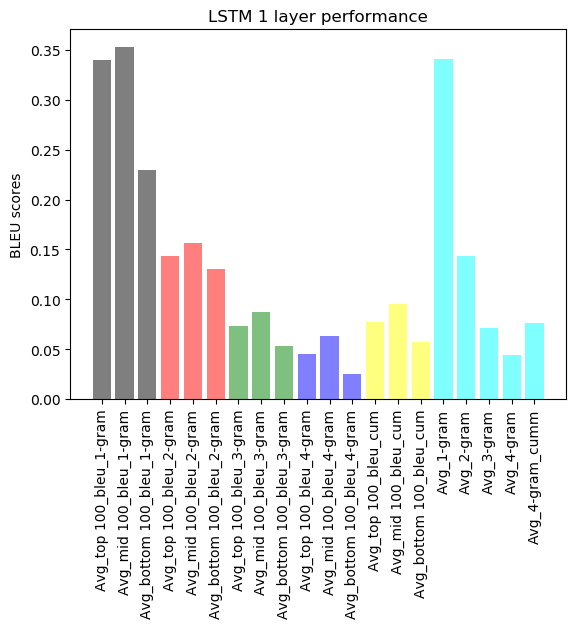

In [24]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Avg_top 100_bleu_1-gram','Avg_mid 100_bleu_1-gram','Avg_bottom 100_bleu_1-gram','Avg_top 100_bleu_2-gram','Avg_mid 100_bleu_2-gram','Avg_bottom 100_bleu_2-gram','Avg_top 100_bleu_3-gram','Avg_mid 100_bleu_3-gram','Avg_bottom 100_bleu_3-gram','Avg_top 100_bleu_4-gram','Avg_mid 100_bleu_4-gram','Avg_bottom 100_bleu_4-gram','Avg_top 100_bleu_cum','Avg_mid 100_bleu_cum','Avg_bottom 100_bleu_cum','Avg_1-gram','Avg_2-gram','Avg_3-gram','Avg_4-gram','Avg_4-gram_cumm')
y_pos = np.arange(len(objects))

performance = [df_bleu_compute['Avg_top 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_1-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_2-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_3-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_4-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_cum'].iloc[0],
               df_bleu_compute['Avg_1-gram'].iloc[0],df_bleu_compute['Avg_2-gram'].iloc[0],df_bleu_compute['Avg_3-gram'].iloc[0],df_bleu_compute['Avg_4-gram'].iloc[0],df_bleu_compute['Avg_4-gram_cumm'].iloc[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['black','black','black', 'red','red','red', 'green','green','green', 'blue', 'blue', 'blue', 'yellow','yellow','yellow','cyan', 'cyan', 'cyan', 'cyan', 'cyan'])
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('BLEU scores')
plt.title('LSTM 1 layer performance')

plt.show()